In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.distributions import Beta
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2Tokenizer

In [2]:
torch.manual_seed(1337)  
np.random.seed(1337)

def beta_bce_variance_loss(alpha, beta, targets, variance_penalty_scale=0.1):
    """
    Computes the BCE loss for the mean of the Beta distribution and adds a penalty for the variance.
    
    Parameters:
    - alpha: Predicted alpha values for the Beta distribution.
    - beta: Predicted beta values for the Beta distribution.
    - targets: Target values for the BCE loss.
    - variance_penalty_scale: Scaling factor for the variance penalty.
    
    Returns:
    - Combined loss value.
    """
    dist = Beta(alpha, beta)
    
    # Mean BCE loss
    mean = dist.mean
    bce_loss = F.binary_cross_entropy(mean, targets.view(mean.shape[0], 1))
    
    # Variance penalty
    variance = dist.variance
    variance_penalty = variance_penalty_scale * variance.mean()
    
    # Combine the losses
    total_loss = bce_loss + variance_penalty
    
    return total_loss


def plot_beta_distribution(a, b):
    from scipy.stats import beta
    
    # Define a range of x values
    linespace = np.linspace(0, 1, 1000)

    # Compute the PDF of the Beta distribution
    pdf_values = beta.pdf(linespace, a, b)

    # Plot the PDF
    plt.figure(figsize=(10, 6))
    plt.plot(linespace, pdf_values, label=f'Beta Distribution (α={a:.3f}, β={b:.3f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('PDF of Beta Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()
    

def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = gpt_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)


class TextDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = generate_embeddings(texts)
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_embedding = self.texts[idx]
        target = self.targets[idx]
        return text_embedding, target


def get_model_prediction_from_test_text(text):
    model.eval()
    with torch.no_grad():
        emb = generate_embeddings(text)
        output = model(emb)
    return output


def create_text_prompt(keyword, location, tweet):
    return f"Keyword: {keyword}\nLocation: {location}\nTweet: {tweet}\n"

In [3]:
# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2Model.from_pretrained('gpt2')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

In [4]:
df = pd.read_csv('train.csv', index_col='id').sample(n=1500, random_state=1337)
df['prompt_text'] = df.apply(lambda row: create_text_prompt(row.keyword, row.location, row.text), axis=1)

In [5]:
train_texts, test_texts, train_targets, test_targets = train_test_split(df['prompt_text'], df['target'], test_size=0.2, random_state=1337)
train_dataset = TextDataset(train_texts.tolist(), train_targets.tolist())
test_dataset = TextDataset(test_texts.tolist(), test_targets.tolist())


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class BetaClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=64):
        super(BetaClassifier, self).__init__()      
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_alpha = nn.Linear(hidden_dim, 1, bias=False)  
        self.fc2_beta = nn.Linear(hidden_dim, 1, bias=False)   
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        alpha = F.softplus(self.fc2_alpha(x)) + 1  # Ensure α > 1 for stability
        beta = F.softplus(self.fc2_beta(x)) + 1    # Ensure β > 1 for stability
        return alpha, beta
    
model = BetaClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for embeddings, labels in train_dataloader:
        optimizer.zero_grad()
        alpha, beta = model(embeddings)
        loss = beta_bce_variance_loss(alpha, beta, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)

    # Testing
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for embeddings, labels in test_dataloader:
            alpha, beta = model(embeddings)
            loss = beta_bce_variance_loss(alpha, beta, labels.float())
            test_loss += loss.item()
            dist = Beta(alpha, beta)
            preds = dist.mean
            all_preds.extend(preds.detach().numpy())
            all_targets.extend(labels.numpy())
    avg_test_loss = test_loss / len(test_dataloader)
    auc = roc_auc_score(all_targets, all_preds)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} => Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, AUC: {auc:.4f}')

Epoch 0 => Train Loss: 0.7018, Test Loss: 0.7013, AUC: 0.6745
Epoch 10 => Train Loss: 0.5529, Test Loss: 0.5448, AUC: 0.8985
Epoch 20 => Train Loss: 0.5308, Test Loss: 0.5377, AUC: 0.9010
Epoch 30 => Train Loss: 0.5217, Test Loss: 0.5364, AUC: 0.9019
Epoch 40 => Train Loss: 0.3782, Test Loss: 0.4115, AUC: 0.8984
Epoch 50 => Train Loss: 0.3450, Test Loss: 0.4358, AUC: 0.8925
Epoch 60 => Train Loss: 0.3321, Test Loss: 0.4291, AUC: 0.8889
Epoch 70 => Train Loss: 0.3137, Test Loss: 0.4336, AUC: 0.8834
Epoch 80 => Train Loss: 0.3025, Test Loss: 0.4413, AUC: 0.8841
Epoch 90 => Train Loss: 0.2822, Test Loss: 0.4639, AUC: 0.8833


Text: Keyword: violent%20storm
Location: Your Six
Tweet: @Vickie627 Desert Storm was an unqualified victory a treaty was signed.  Under Clinton the situation only got worse and more violent. #tcot

Prediction: α=2.28, β=5.45
Probability: 0.30
True label: 1
Variance: 0.02383


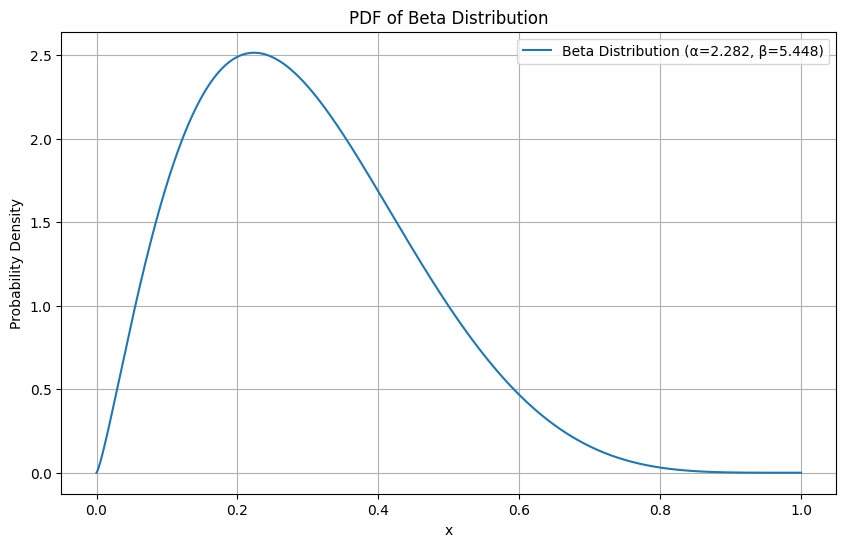

In [9]:
def analyze_text_prediction(text=None):
    if text is None:
        random_index = random.choice(test_texts.index)
        text, target = test_texts.loc[random_index], test_targets.loc[random_index]
    
    else:
        target = 'No target available.'

    a, b = get_model_prediction_from_test_text(text)
    print(f'Text: {text}')
    print(f'Prediction: α={a.item():.2f}, β={b.item():.2f}')
    beta_dist = Beta(a, b)
    print(f'Probability: {beta_dist.mean.item():.2f}')
    print(f'True label: {target}')
    print(f'Variance: {beta_dist.variance.item():.5f}')
    plot_beta_distribution(a.item(), b.item())

analyze_text_prediction()